In [1]:
import tensorflow as tf
print(tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from func1 import *
from query1 import *
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


Using TensorFlow backend.


In [2]:
df = data1()
print("raw of shape ", df.shape)
df.index = df['timestamp']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("dropna ", df.shape)

raw of shape  (2400, 27)
dropna  (2400, 27)


In [3]:
rawdata = df[['Q']].iloc[2000:,:]
rawdata.to_csv('rawQ.csv')

In [4]:
# df.info()
# df.tail(2)

dtat0 = df.iloc[-1:,0:1].values[0][0]
dti = pd.date_range(dtat0, periods=2, freq='0.5H').shift(1,freq='0.5H')
dfdt = dti.to_frame(index=False, name='datims')
df.drop(('timestamp'), axis=1, inplace=True)
# dfdt

In [6]:
print(dtat0)
print(dti)
print(dfdt)

2020-05-25T14:30:00.000000000
DatetimeIndex(['2020-05-25 15:00:00', '2020-05-25 15:30:00'], dtype='datetime64[ns]', freq='30T')
               datims
0 2020-05-25 15:00:00
1 2020-05-25 15:30:00


In [7]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['Q']])

X_scaler = MinMaxScaler()

df[['MW', 'MVAR', 'SlotA1', 'SlotA2', 'SlotA3', 'SlotB1', 'SlotB2',
       'SlotB3', 'SlotC1', 'SlotC2', 'SlotC3', '26AIS1', '26AIS2', '26AIS3',
       '26AIS4', '26AOS1', '26AOS2', '26AOS3', '26AOS4', '26AIS', '26AOS',
       'dTemp', 'F', 'Cp', 'p', 'Q']] = X_scaler.fit_transform(df)

In [8]:
df.tail(2)

,MW,MVAR,SlotA1,SlotA2,SlotA3,SlotB1,SlotB2,SlotB3,SlotC1,SlotC2,...,26AOS2,26AOS3,26AOS4,26AIS,26AOS,dTemp,F,Cp,p,Q
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-25 13:30:00,0.705489,0.526519,0.453777,0.449288,0.451657,0.449379,0.455044,0.454018,0.455311,0.449481,...,0.650461,0.447321,0.162504,0.526973,0.496855,0.381872,0.0,0.0,0.0,0.382022
2020-05-25 14:30:00,0.664514,0.549984,0.470970,0.465773,0.468091,0.465931,0.470121,0.472295,0.472154,0.470235,...,0.754401,0.478627,0.166374,0.610889,0.559748,0.454681,0.0,0.0,0.0,0.454814


In [9]:
dfval = df.values
print(type(dfval), dfval.shape) # (1000, 30) = (sample, features)

<class 'numpy.ndarray'> (2400, 26)


In [10]:
n_steps_in, n_steps_out = 3, 2

# convert into input/output
X, y = split_sequences(dfval, n_steps_in, n_steps_out)
print(X.shape)

X_train = X[:2000,:]
X_test = X[2000:,:]

y_train = y[:2000,:]
y_test = y[2000:,:]


print(X_train.shape) # (2000, 3, 25) = (samples, n_steps_in, n_features)
print(X_test.shape) # (397, 2) = (samples, n_steps_out)

print(y_train.shape) # (2000, 3, 25) = (samples, n_steps_in, n_features)
print(y_test.shape) # (397, 2) = (samples, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

(2397, 3, 25)
(2000, 3, 25)
(397, 3, 25)
(2000, 2)
(397, 2)


In [82]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [83]:
# fit model
save_path = 'models/'
filepath=save_path+"weights-v-{epoch:02d}.hdf5"
checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=1000, verbose=1, callbacks=[checkpointer])

Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 3s 2ms/step - loss: 0.1089 - val_loss: 0.0118

Epoch 00001: val_loss improved from inf to 0.01178, saving model to models/weights-v-01.hdf5
Epoch 2/1000
1600/1600 [==============================] - 0s 133us/step - loss: 0.0146 - val_loss: 0.0236

Epoch 00002: val_loss did not improve from 0.01178
Epoch 3/1000
1600/1600 [==============================] - 0s 140us/step - loss: 0.0097 - val_loss: 0.0178

Epoch 00003: val_loss did not improve from 0.01178
Epoch 4/1000
1600/1600 [==============================] - 0s 106us/step - loss: 0.0084 - val_loss: 0.0164

Epoch 00004: val_loss did not improve from 0.01178
Epoch 5/1000
1600/1600 [==============================] - 0s 144us/step - loss: 0.0074 - val_loss: 0.0131

Epoch 00005: val_loss did not improve from 0.01178
Epoch 6/1000
1600/1600 [==============================] - 0s 141us/step - loss: 0.0066 - val_loss: 0.0095

Epoch 00006: val

Epoch 93/1000
1600/1600 [==============================] - 0s 133us/step - loss: 0.0026 - val_loss: 0.0024

Epoch 00093: val_loss did not improve from 0.00228
Epoch 94/1000
1600/1600 [==============================] - 0s 175us/step - loss: 0.0025 - val_loss: 0.0023

Epoch 00094: val_loss improved from 0.00228 to 0.00226, saving model to models/weights-v-94.hdf5
Epoch 95/1000
1600/1600 [==============================] - 0s 147us/step - loss: 0.0026 - val_loss: 0.0025

Epoch 00095: val_loss did not improve from 0.00226
Epoch 96/1000
1600/1600 [==============================] - 0s 168us/step - loss: 0.0026 - val_loss: 0.0023

Epoch 00096: val_loss did not improve from 0.00226
Epoch 97/1000
1600/1600 [==============================] - 0s 146us/step - loss: 0.0024 - val_loss: 0.0025

Epoch 00097: val_loss did not improve from 0.00226
Epoch 98/1000
1600/1600 [==============================] - 0s 144us/step - loss: 0.0024 - val_loss: 0.0028

Epoch 00098: val_loss did not improve from 0.00226


1600/1600 [==============================] - 0s 121us/step - loss: 0.0023 - val_loss: 0.0025

Epoch 00194: val_loss did not improve from 0.00214
Epoch 195/1000
1600/1600 [==============================] - 0s 151us/step - loss: 0.0022 - val_loss: 0.0026

Epoch 00195: val_loss did not improve from 0.00214
Epoch 196/1000
1600/1600 [==============================] - 0s 146us/step - loss: 0.0024 - val_loss: 0.0030

Epoch 00196: val_loss did not improve from 0.00214
Epoch 197/1000
1600/1600 [==============================] - 0s 140us/step - loss: 0.0023 - val_loss: 0.0023

Epoch 00197: val_loss did not improve from 0.00214
Epoch 198/1000
1600/1600 [==============================] - 0s 138us/step - loss: 0.0022 - val_loss: 0.0025

Epoch 00198: val_loss did not improve from 0.00214
Epoch 199/1000
1600/1600 [==============================] - 0s 137us/step - loss: 0.0022 - val_loss: 0.0026

Epoch 00199: val_loss did not improve from 0.00214
Epoch 200/1000
1600/1600 [=============================

1600/1600 [==============================] - 0s 114us/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00296: val_loss did not improve from 0.00214
Epoch 297/1000
1600/1600 [==============================] - 0s 129us/step - loss: 0.0021 - val_loss: 0.0026

Epoch 00297: val_loss did not improve from 0.00214
Epoch 298/1000
1600/1600 [==============================] - 0s 139us/step - loss: 0.0020 - val_loss: 0.0022

Epoch 00298: val_loss did not improve from 0.00214
Epoch 299/1000
1600/1600 [==============================] - 0s 146us/step - loss: 0.0021 - val_loss: 0.0024

Epoch 00299: val_loss did not improve from 0.00214
Epoch 300/1000
1600/1600 [==============================] - 0s 138us/step - loss: 0.0020 - val_loss: 0.0024

Epoch 00300: val_loss did not improve from 0.00214
Epoch 301/1000
1600/1600 [==============================] - 0s 133us/step - loss: 0.0021 - val_loss: 0.0024

Epoch 00301: val_loss did not improve from 0.00214
Epoch 302/1000
1600/1600 [=============================

1600/1600 [==============================] - 0s 113us/step - loss: 0.0018 - val_loss: 0.0023

Epoch 00398: val_loss did not improve from 0.00214
Epoch 399/1000
1600/1600 [==============================] - 0s 150us/step - loss: 0.0019 - val_loss: 0.0023

Epoch 00399: val_loss did not improve from 0.00214
Epoch 400/1000
1600/1600 [==============================] - 0s 114us/step - loss: 0.0020 - val_loss: 0.0022

Epoch 00400: val_loss did not improve from 0.00214
Epoch 401/1000
1600/1600 [==============================] - 0s 110us/step - loss: 0.0019 - val_loss: 0.0024

Epoch 00401: val_loss did not improve from 0.00214
Epoch 402/1000
1600/1600 [==============================] - 0s 123us/step - loss: 0.0018 - val_loss: 0.0023

Epoch 00402: val_loss did not improve from 0.00214
Epoch 403/1000
1600/1600 [==============================] - 0s 137us/step - loss: 0.0019 - val_loss: 0.0025

Epoch 00403: val_loss did not improve from 0.00214
Epoch 404/1000
1600/1600 [=============================

1600/1600 [==============================] - 0s 127us/step - loss: 0.0018 - val_loss: 0.0025

Epoch 00500: val_loss did not improve from 0.00214
Epoch 501/1000
1600/1600 [==============================] - 0s 137us/step - loss: 0.0018 - val_loss: 0.0025

Epoch 00501: val_loss did not improve from 0.00214
Epoch 502/1000
1600/1600 [==============================] - 0s 137us/step - loss: 0.0019 - val_loss: 0.0026

Epoch 00502: val_loss did not improve from 0.00214
Epoch 503/1000
1600/1600 [==============================] - 0s 138us/step - loss: 0.0018 - val_loss: 0.0024

Epoch 00503: val_loss did not improve from 0.00214
Epoch 504/1000
1600/1600 [==============================] - 0s 138us/step - loss: 0.0019 - val_loss: 0.0025

Epoch 00504: val_loss did not improve from 0.00214
Epoch 505/1000
1600/1600 [==============================] - 0s 136us/step - loss: 0.0019 - val_loss: 0.0024

Epoch 00505: val_loss did not improve from 0.00214
Epoch 506/1000
1600/1600 [=============================

1600/1600 [==============================] - 0s 124us/step - loss: 0.0017 - val_loss: 0.0027

Epoch 00602: val_loss did not improve from 0.00214
Epoch 603/1000
1600/1600 [==============================] - 0s 149us/step - loss: 0.0018 - val_loss: 0.0027

Epoch 00603: val_loss did not improve from 0.00214
Epoch 604/1000
1600/1600 [==============================] - 0s 143us/step - loss: 0.0017 - val_loss: 0.0027

Epoch 00604: val_loss did not improve from 0.00214
Epoch 605/1000
1600/1600 [==============================] - 0s 109us/step - loss: 0.0017 - val_loss: 0.0029

Epoch 00605: val_loss did not improve from 0.00214
Epoch 606/1000
1600/1600 [==============================] - 0s 98us/step - loss: 0.0017 - val_loss: 0.0026

Epoch 00606: val_loss did not improve from 0.00214
Epoch 607/1000
1600/1600 [==============================] - 0s 142us/step - loss: 0.0017 - val_loss: 0.0028

Epoch 00607: val_loss did not improve from 0.00214
Epoch 608/1000
1600/1600 [==============================

1600/1600 [==============================] - 0s 128us/step - loss: 0.0018 - val_loss: 0.0028

Epoch 00704: val_loss did not improve from 0.00214
Epoch 705/1000
1600/1600 [==============================] - 0s 113us/step - loss: 0.0016 - val_loss: 0.0029

Epoch 00705: val_loss did not improve from 0.00214
Epoch 706/1000
1600/1600 [==============================] - 0s 99us/step - loss: 0.0016 - val_loss: 0.0030

Epoch 00706: val_loss did not improve from 0.00214
Epoch 707/1000
1600/1600 [==============================] - 0s 99us/step - loss: 0.0016 - val_loss: 0.0028

Epoch 00707: val_loss did not improve from 0.00214
Epoch 708/1000
1600/1600 [==============================] - 0s 114us/step - loss: 0.0016 - val_loss: 0.0029

Epoch 00708: val_loss did not improve from 0.00214
Epoch 709/1000
1600/1600 [==============================] - 0s 77us/step - loss: 0.0016 - val_loss: 0.0030

Epoch 00709: val_loss did not improve from 0.00214
Epoch 710/1000
1600/1600 [==============================] 

1600/1600 [==============================] - 0s 116us/step - loss: 0.0015 - val_loss: 0.0030

Epoch 00806: val_loss did not improve from 0.00214
Epoch 807/1000
1600/1600 [==============================] - 0s 76us/step - loss: 0.0016 - val_loss: 0.0030

Epoch 00807: val_loss did not improve from 0.00214
Epoch 808/1000
1600/1600 [==============================] - 0s 119us/step - loss: 0.0015 - val_loss: 0.0029

Epoch 00808: val_loss did not improve from 0.00214
Epoch 809/1000
1600/1600 [==============================] - 0s 144us/step - loss: 0.0016 - val_loss: 0.0031

Epoch 00809: val_loss did not improve from 0.00214
Epoch 810/1000
1600/1600 [==============================] - 0s 141us/step - loss: 0.0016 - val_loss: 0.0036

Epoch 00810: val_loss did not improve from 0.00214
Epoch 811/1000
1600/1600 [==============================] - 0s 75us/step - loss: 0.0016 - val_loss: 0.0030

Epoch 00811: val_loss did not improve from 0.00214
Epoch 812/1000
1600/1600 [==============================]

1600/1600 [==============================] - 0s 138us/step - loss: 0.0015 - val_loss: 0.0034

Epoch 00908: val_loss did not improve from 0.00214
Epoch 909/1000
1600/1600 [==============================] - 0s 142us/step - loss: 0.0015 - val_loss: 0.0033

Epoch 00909: val_loss did not improve from 0.00214
Epoch 910/1000
1600/1600 [==============================] - 0s 141us/step - loss: 0.0016 - val_loss: 0.0032

Epoch 00910: val_loss did not improve from 0.00214
Epoch 911/1000
1600/1600 [==============================] - 0s 141us/step - loss: 0.0015 - val_loss: 0.0035

Epoch 00911: val_loss did not improve from 0.00214
Epoch 912/1000
1600/1600 [==============================] - 0s 144us/step - loss: 0.0016 - val_loss: 0.0036

Epoch 00912: val_loss did not improve from 0.00214
Epoch 913/1000
1600/1600 [==============================] - 0s 143us/step - loss: 0.0016 - val_loss: 0.0035

Epoch 00913: val_loss did not improve from 0.00214
Epoch 914/1000
1600/1600 [=============================

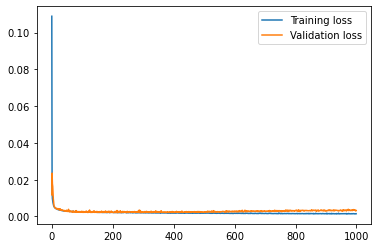

In [84]:
# plot metrics
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')

# pyplot.plot(history.history['mean_absolute_percentage_error'])
plt.legend()
pyplot.show()

In [85]:
print(history.history.keys())
print(np.argmin(np.array(history.history['val_loss']))+1)

yhat = model.predict(X_test, verbose=1)
yp = y_scaler.inverse_transform(yhat)
ya = y_scaler.inverse_transform(y_test)

dict_keys(['val_loss', 'loss'])
245
397/397 [==============================] - 0s 845us/step


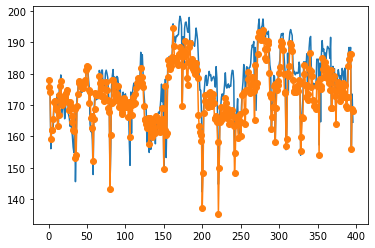

In [86]:
# T1
plt.plot(ya[:,:1])
plt.plot(yp[:,:1],marker='o')

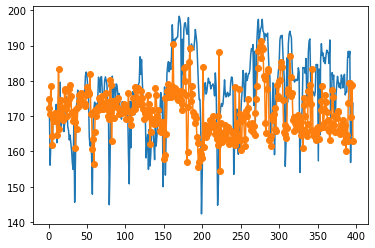

In [87]:
# T2
plt.plot(ya[:,-1:])
plt.plot(yp[:,-1:],marker='o')

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms = sqrt(mean_squared_error(yp[:,:1], ya[:,:1]))
# rms_total = (rms*100)/8453.7852
# rms_total

In [88]:
actual = pd.DataFrame(ya[:,:1])
pred = pd.DataFrame(yp[:,:1])
print(actual.shape, pred.shape)
com = pd.concat([actual, pred], axis=1, join='inner')
com.columns = ['Act_T1','Pred_T1']
print(com.shape)
com.to_csv('model1_T1.csv')

(397, 1) (397, 1)
(397, 2)


In [89]:
actual = pd.DataFrame(ya[:,-1:])
pred = pd.DataFrame(yp[:,-1:])
print(actual.shape, pred.shape)
com = pd.concat([actual, pred], axis=1, join='inner')
com.columns = ['Act_T2','Pred_T2']
print(com.shape)
com.to_csv('model1_T2.csv')

(397, 1) (397, 1)
(397, 2)
